Demo: How to use glm_utils, and GLM basics
===

In this demo we will demostrate how to use glm_utils as we go through a basic example. We will emphasize important steps in the process, as well as potential mistakes.

## Importing required dependencies

We will start importing the required dependencies.

In [4]:
from glm_utils.preprocessing import time_delay_embedding, BasisProjection
from glm_utils.bases import raised_cosine, multifeature_basis
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model as lm
import scipy.signal
from demo_utils import get_data
plt.style.use('ncb.mplstyle')

# Priority list:
# TODO: add train-test split.
# TODO: add plot comparing "relevance" of each input to the model (compare coefficients/filter-magnitudes).
# TODO: add an example with irrelevant features for choice of features.
# TODO: add an example for redundant variables.
# TODO: show problems of not normalizing your inputs in a separate box.

# Enhancements list:
# TODO: add an "observe your data" box in the first steps, to show how to examine what kind of data you have (histograms and feature vs signal scatter plot, looking for clear linear relationships, or to see what kind of transformation to apply to the features to make them more relevant, e.g. absolute value).
# TODO: fix 'estimated' and 'true' labels for overlapped filters graph
# TODO: add option for noise in get_data.


# Get data

The first step will be to get our data. In our demo we will work with a signal (y) which has been constructed from normalized randomly generated inputs (x, 4 inputs), which have been filtered with known kernels (filters, 4 filters with length of 50 elements). Through the upcoming examples we may add, remove or modify these arrays. Once you are done with the demo, you may change these arrays with your own data.

Note: keep in mind that depending on the structure of your data you might need to pre-process your data (don't forget to normalize, as will be shown later).

Tip: for data collected from multiple sources (experiments, individuals, trials, ...), it is recommended to store the time-delay-embedding (will be explained later) of the specific data points that you are interested.

x: (2000, 4), y: (2000,), filters (50, 4)


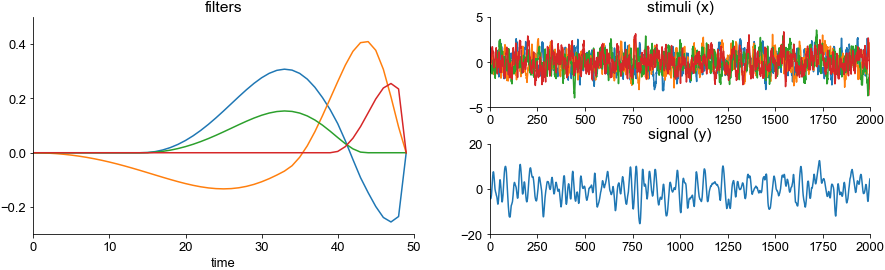

In [3]:

x, y, filters = get_data()

npoints, ninputs = x.shape

print(f"x: {x.shape}, y: {y.shape}, filters {filters.shape}")
plt.figure(figsize=[15,4])
plt.subplot(121)
plt.plot(filters)
plt.title('filters')
plt.xlabel('time')
plt.subplot(222)
plt.plot(x)
plt.title('stimuli (x)')
plt.subplot(224)
plt.plot(y)
plt.title('signal (y)')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Define a basis

In this pipeline, we will project our features to a set of bases, to account for multiple time scales in the model. To start, we will use raised cosines.

Because our models will consider multiple features, the input to the model will consist of a concatenation of the projections. Therefore, we will transform our bases accordingly. Fortunately, glm_utils contains a function that will take our individual set of bases and transform it into the corresponding set array of bases for the given number of inputs.

In order to project our data to our bases, as well as reconstructing our filters, we will initialize a BasisProjection, which takes our array of bases and will make use of them as we need.

Note: it is good practice to inspect your bases to make sure they have the correct window size (time span that they will integrate), and that they cover this window as you desire.

Tip: glm_utils also contains a function to generate laplacian bases (laplacian_pyramid in glm_utils.bases), which is usually more detailed, but also takes much more computation time, as the number of bases increases significantly.

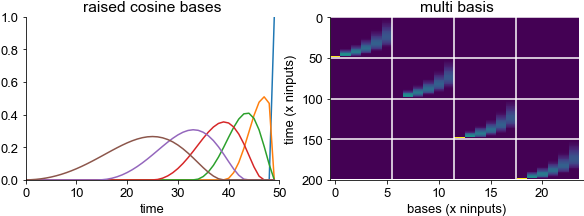

In [6]:
# define bases
B = raised_cosine(1, 5, [1, 23], 9)
B_multi = multifeature_basis(B, ninputs)  # should explain what/why we do this here
basis_multi_projection = BasisProjection(B_multi)  # should explain what/why we do this here
window_size, nbases = B.shape

plt.figure(figsize = [10,3])
plt.subplot(121)
plt.plot(B)
plt.title('raised cosine bases')
plt.xlabel('time')

plt.subplot(122) # more info on this plot, such as better axis and division labels
plt.imshow(B_multi)
plt.hlines(np.arange(0, ninputs*window_size,window_size), -0.5, B_multi.shape[1], colors='w')
plt.vlines(np.arange(0, ninputs*nbases,nbases)-0.5, 0, B_multi.shape[0], colors='w')
plt.axis('tight')
plt.ylabel('time (x ninputs)')
plt.xlabel('bases (x ninputs)')
plt.title('multi basis')
plt.show()

# Time-delay-embedding

To project our data, we need to recover not just the desired data point, but also a time window before each data point collected. Luckily, glm_utils also provides a simple function which will take your inputs, signal, and the desired window size (here set to be equal to the window size of our bases, which is required in future steps, although you can collect longer window sizes and preprocess the data to fit the window size before projection).

Note: the size of the outputs will be a reduced version of the inputs, as the window size is too big for the first elements. This shape of the outputs will be missing as many elements as the size of your window.

In [7]:
# time-delay-embedding
Xmulti, ymulti = time_delay_embedding(x, y, window_size=window_size, flatten_inside_window=True)

print(f"Xmulti: {Xmulti.shape}, ymulti: {ymulti.shape}")

Xmulti: (1950, 200), ymulti: (1950,)


# Sample

In order to train and test our models, we need to split our data. This is also required to test multiple models with the same data points. There is many ways to do this split of data. Here we will split the data into 3:1 train to test ratio. In order to keep the same test group across all examples, we will save the indices of the train/test data points.

In [12]:
# choose how many random samples to take from the data (less or equal than the available data, npoints)
ntestsamples = int(ymulti.shape[0]/3)
test_idxs = np.random.choice(np.arange(ymulti.shape[0]),ntestsamples,replace=False)
train_idxs = np.squeeze(np.argwhere(~np.isin(np.arange(ymulti.shape[0]),test_idxs)))
print(f"test_idxs: {test_idxs.shape}, train_idxs: {train_idxs.shape}")


test_idxs: (650,), train_idxs: (1300,)


# Project

In order to project, we only need to call the method "transform" within our BasisProjection class, giving the data we desire to project.

In [14]:
# project
Xmulti_b = basis_multi_projection.transform(Xmulti)


# Train

Now that we have preprocessed our data correctly using the tools that glm_utils provides to us, we can train a glm model simply choosing our type of model and feeding it with the data. We will do this using sklearn linear models. As a first indication of how well the model trained is, we can score our model with the test data we splitted before. In our case (LinearRegression) the score is the coefficient of determination, and our model results in a perfect match to the data.

Note: depending on the type of data, you will need to choose the correct type of model, and the score function will as well change accordingly, so take a minute to think what fits the best to your case before running this.

In [17]:
lr = lm.LinearRegression()
lr.fit(Xmulti_b[train_idxs], ymulti[train_idxs])
print(f'score: {lr.score(Xmulti_b[test_idxs], ymulti[test_idxs])}')

score: 1.0


# Filter reconstruction

Knowing that the model fits the data is good, but to interpret the model that was found we need to reconstruct the filters that the model has assigned to each feature. To do this, we just need to extract the coefficients of our linear model associated to each feature's projection, and make use again of a method within our BasisProjection class, called "inverse_transform", which will return to us our estimated filters. Nevertheless, we have to remember that our inputs were concatenated, and so will be our estimated filters, so we need to reshape the output accordingly.

Text(0.5, 1.0, 'filters')

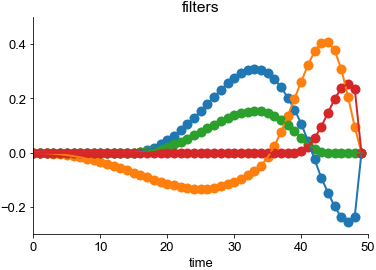

In [21]:
basis_weights = lr.coef_
estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,window_size))

for ii in range(ninputs):
    plt.plot(estimated_filters[ii], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(filters, linewidth=2)
plt.xlabel('time')
plt.title('filters')

# With noise    (bookmark, this and below is were adrian is editing at the moment)

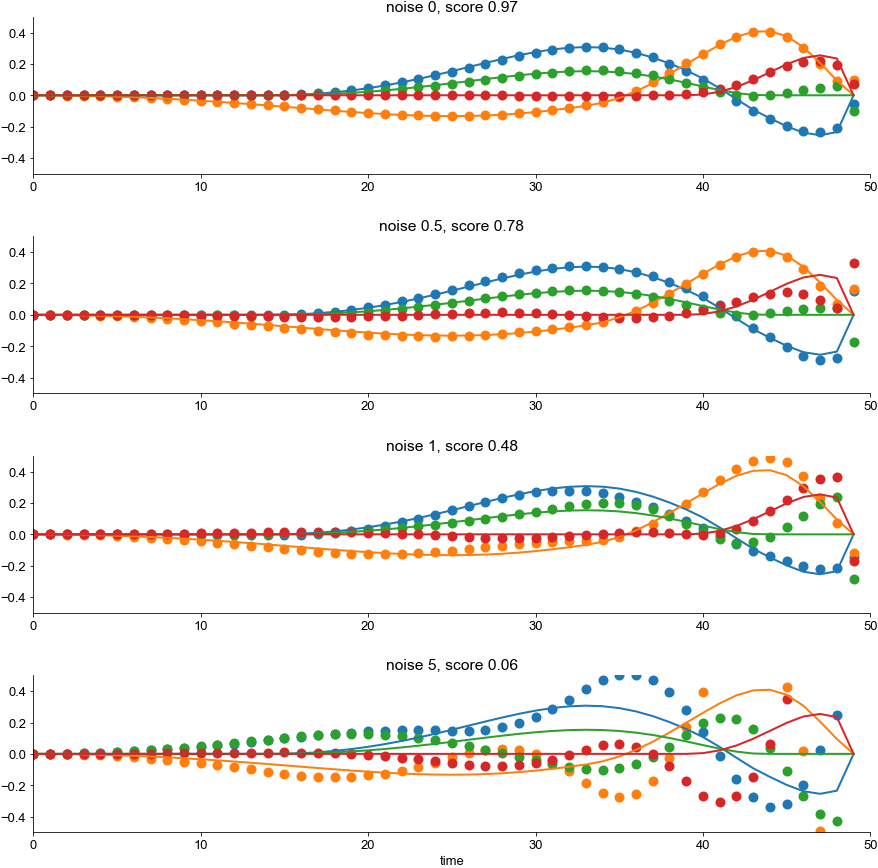

In [18]:
noise_levels = [0,0.5,1,5]
plt.figure(figsize=[15,15])
for ii, noise_level in enumerate(noise_levels):
    plt.subplot(len(noise_levels),1,ii+1)

    y_noisy = ymulti + np.random.normal(ymulti.mean(), ymulti.std(), ymulti.shape[0])*noise_level # add noise to signal

    # train
    lr = lm.LinearRegression()
    lr.fit(Xmulti_b, y_noisy)

    # reconstruct
    basis_weights = lr.coef_
    estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
    estimated_filters = np.squeeze(estimated_filters)

    # plot
    for ii in range(ninputs):
        plt.plot(estimated_filters[ii*window_size:(ii+1)*window_size], 'o', linewidth=2, markersize=10)
    plt.ylim([-0.5,0.5])
    plt.gca().set_prop_cycle(None)
    plt.plot(filters, linewidth=2)
    plt.title(f'noise {noise_level}, score {lr.score(Xmulti_b, y_noisy):0.2f}')
plt.xlabel('time')
plt.subplots_adjust(hspace=0.4)
plt.show()

# Incomplete inputs

score: 0.8168600315695405


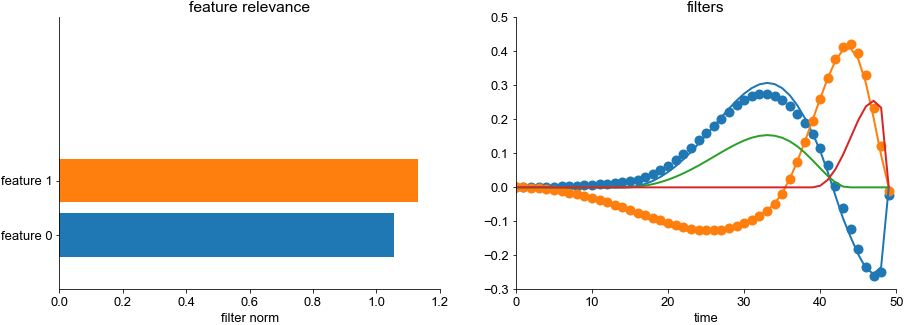

In [36]:
# data
x, y, filters = get_data()
x = x[:,:2] # remove one of the original inputs
npoints, ninputs = x.shape

# bases
B = glm_utils.bases.raised_cosine(1, 5, [1, 23], 9)
B_multi = glm_utils.bases.multifeature_basis(B, ninputs)  # should explain what/why we do this here
basis_multi_projection = BasisProjection(B_multi)  # should explain what/why we do this here
window_size, nbases = B.shape

# time-delay-embedding
Xmulti, ymulti = time_delay_embedding(x, y, window_size=window_size, flatten_inside_window=True)

# choose how many random samples to take from the data (less or equal than the available data, npoints)
nsamples = 1000
sample_idxs = np.random.choice(np.arange(ymulti.shape[0]),nsamples,replace=False)

# sample
Xmulti = Xmulti[sample_idxs]
ymulti = ymulti[sample_idxs]

# project
Xmulti_b = basis_multi_projection.transform(Xmulti)

# train
lr = lm.LinearRegression()
lr.fit(Xmulti_b, ymulti)
print('score:',lr.score(Xmulti_b, ymulti))

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
estimated_filters = np.squeeze(estimated_filters)    # inverse transform returns a [1, ncoefs] array

# plot
features_names = [f'feature {ii}' for ii in range(ninputs)]
plt.figure(figsize=[15,5])
plt.subplot(121)
for ii in range(ninputs):
    frob_norm = np.linalg.norm(estimated_filters[ii*window_size:(ii+1)*window_size])
    plt.barh(ii,frob_norm)
plt.yticks(np.arange(ninputs),features_names)
plt.xlabel('filter norm')
plt.title('feature relevance')
plt.ylim([-1,4])
plt.subplot(122)
for ii in range(ninputs):
    plt.plot(estimated_filters[ii*window_size:(ii+1)*window_size], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(filters, linewidth=2)
plt.xlabel('time')
plt.title('filters')
plt.show()

# Irrelevant features

score: 1.0


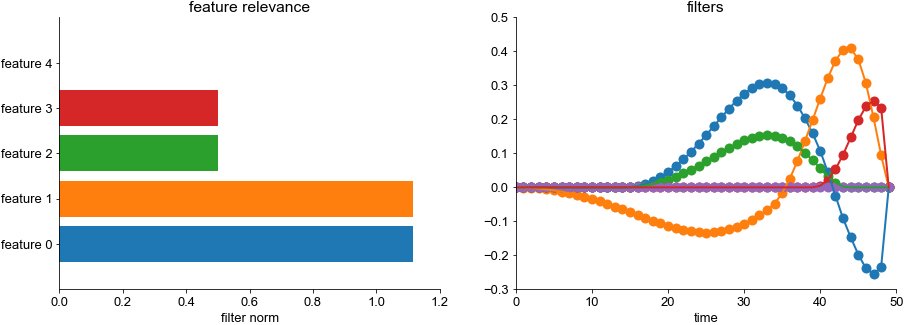

In [52]:
# data
x, y, filters = get_data()
x = np.concatenate((x,np.random.normal(0, 1, x[:,0].shape)[:,np.newaxis]),axis=1) # add a normaly distributed variable
npoints, ninputs = x.shape

# bases
B = glm_utils.bases.raised_cosine(1, 5, [1, 23], 9)
B_multi = glm_utils.bases.multifeature_basis(B, ninputs)  # should explain what/why we do this here
basis_multi_projection = BasisProjection(B_multi)  # should explain what/why we do this here
window_size, nbases = B.shape

# time-delay-embedding
Xmulti, ymulti = time_delay_embedding(x, y, window_size=window_size, flatten_inside_window=True)

# choose how many random samples to take from the data (less or equal than the available data, npoints)
nsamples = 1000
sample_idxs = np.random.choice(np.arange(ymulti.shape[0]),nsamples,replace=False)

# sample
Xmulti = Xmulti[sample_idxs]
ymulti = ymulti[sample_idxs]

# project
Xmulti_b = basis_multi_projection.transform(Xmulti)

# train
lr = lm.LinearRegression()
lr.fit(Xmulti_b, ymulti)
print('score:',lr.score(Xmulti_b, ymulti))

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
estimated_filters = np.squeeze(estimated_filters)    # inverse transform returns a [1, ncoefs] array

# plot
features_names = [f'feature {ii}' for ii in range(ninputs)]
plt.figure(figsize=[15,5])
plt.subplot(121)
for ii in range(ninputs):
    frob_norm = np.linalg.norm(estimated_filters[ii*window_size:(ii+1)*window_size])
    plt.barh(ii,frob_norm)
plt.yticks(np.arange(ninputs),features_names)
plt.xlabel('filter norm')
plt.title('feature relevance')
plt.subplot(122)
for ii in range(ninputs):
    plt.plot(estimated_filters[ii*window_size:(ii+1)*window_size], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(filters, linewidth=2)
plt.xlabel('time')
plt.title('filters')
plt.show()

# save previous results for comparison
integrated_model_filters = estimated_filters
integrated_model_score = lr.score(Xmulti_b, ymulti)

# Individual models vs Integrated models

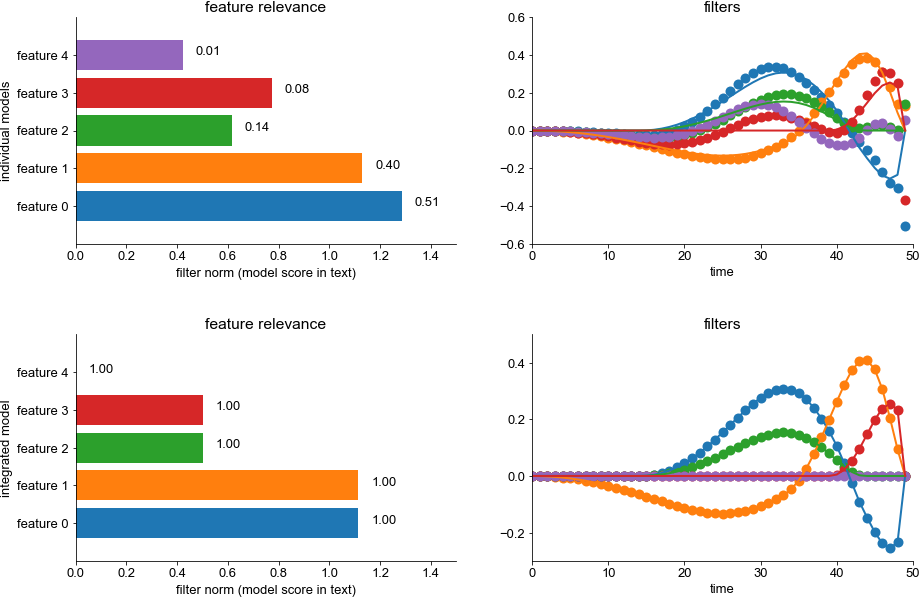

In [55]:
# indidivual basis
basis_projection = BasisProjection(B)

# lists to collect results per individual model
scores_list = []
estimated_filters_list = []

for ii in range(ninputs):

    # time-delay-embedding
    Xs, ys = time_delay_embedding(x[:,ii], y, window_size=window_size, flatten_inside_window=True)

    # sample
    Xs = Xs[sample_idxs]
    ys = ys[sample_idxs]

    # project
    Xs_b = basis_projection.transform(Xs)

    # train
    lr = lm.LinearRegression()
    lr.fit(Xs_b, ys)

    # reconstruct
    basis_weights = lr.coef_
    estimated_filters = basis_projection.inverse_transform(basis_weights)
    estimated_filters = np.squeeze(estimated_filters)    # inverse transform returns a [1, ncoefs] array

    scores_list.append(lr.score(Xs_b, ys))
    estimated_filters_list.append(estimated_filters)


# plot
features_names = [f'feature {ii}' for ii in range(ninputs)]
plt.figure(figsize=[15,10])
plt.subplot(221)
for ii in range(ninputs):
    estimated_filter = estimated_filters_list[ii]
    frob_norm = np.linalg.norm(estimated_filter)
    plt.barh(ii,frob_norm)
    plt.text(frob_norm+0.05, ii, s=f"{scores_list[ii]:0.2f}")
plt.yticks(np.arange(ninputs),features_names)
plt.xlabel('filter norm (model score in text)')
plt.title('feature relevance')
plt.ylabel('individual models')
plt.xlim([0,1.5])
plt.subplot(222)
for ii in range(ninputs):
    plt.plot(estimated_filters_list[ii], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(filters, linewidth=2)
plt.xlabel('time')
plt.title('filters')

plt.subplot(223)
for ii in range(ninputs):
    frob_norm = np.linalg.norm(integrated_model_filters[ii*window_size:(ii+1)*window_size])
    plt.barh(ii,frob_norm)
    plt.text(frob_norm+0.05, ii, s=f"{integrated_model_score:0.2f}")
plt.yticks(np.arange(ninputs),features_names)
plt.xlabel('filter norm (model score in text)')
plt.title('feature relevance')
plt.ylabel('integrated model')
plt.xlim([0,1.5])
plt.subplot(224)
for ii in range(ninputs):
    plt.plot(integrated_model_filters[ii*window_size:(ii+1)*window_size], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(filters, linewidth=2)
plt.xlabel('time')
plt.title('filters')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Redundant features

lr score: 1.0
lasso score: 0.9554384561669026


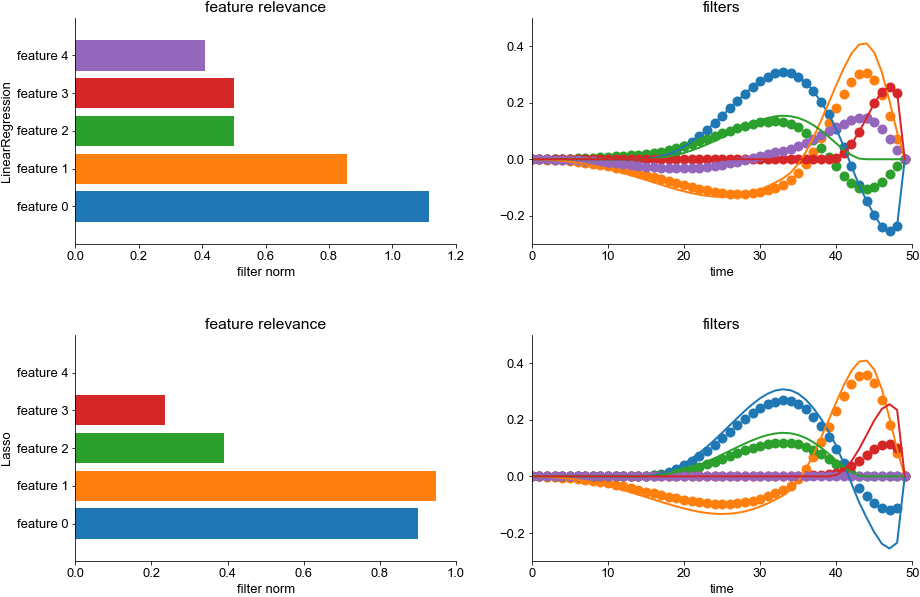

In [42]:
# data
x, y, filters = get_data()
x = np.concatenate((x,x[:,[1]]+x[:,[2]]),axis=1)
x[:,-1] = (x[:,-1] - np.mean(x[:,-1]))/np.std(x[:,-1]) # normalize new feature
npoints, ninputs = x.shape

# bases
B = glm_utils.bases.raised_cosine(1, 5, [1, 23], 9)
B_multi = glm_utils.bases.multifeature_basis(B, ninputs)  # should explain what/why we do this here
basis_multi_projection = BasisProjection(B_multi)  # should explain what/why we do this here
window_size, nbases = B.shape

# time-delay-embedding
Xmulti, ymulti = time_delay_embedding(x, y, window_size=window_size, flatten_inside_window=True)

# choose how many random samples to take from the data (less or equal than the available data, npoints)
nsamples = 1000
sample_idxs = np.random.choice(np.arange(ymulti.shape[0]),nsamples,replace=False)

# sample
Xmulti = Xmulti[sample_idxs]
ymulti = ymulti[sample_idxs]

# project
Xmulti_b = basis_multi_projection.transform(Xmulti)

# train
lr = lm.LinearRegression()
lr.fit(Xmulti_b, ymulti)
print('lr score:',lr.score(Xmulti_b, ymulti))

# train (with lasso)
lr_lasso = lm.Lasso()
lr_lasso.fit(Xmulti_b, ymulti)
print('lasso score:',lr_lasso.score(Xmulti_b, ymulti))

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
estimated_filters = np.squeeze(estimated_filters)    # inverse transform returns a [1, ncoefs] array

# reconstruct (with lasso)
basis_weights_lasso = lr_lasso.coef_
estimated_filters_lasso = basis_multi_projection.inverse_transform(basis_weights_lasso)
estimated_filters_lasso = np.squeeze(estimated_filters_lasso)    # inverse transform returns a [1, ncoefs] array

# relevance plot for lr
features_names = [f'feature {ii}' for ii in range(ninputs)]
plt.figure(figsize=[15,10])
plt.subplot(221)
for ii in range(ninputs):
    frob_norm = np.linalg.norm(estimated_filters[ii*window_size:(ii+1)*window_size])
    plt.barh(ii,frob_norm)
plt.yticks(np.arange(ninputs),features_names)
plt.xlabel('filter norm')
plt.title('feature relevance')
plt.ylabel('LinearRegression')
plt.subplot(222)
for ii in range(ninputs):
    plt.plot(estimated_filters[ii*window_size:(ii+1)*window_size], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(filters, linewidth=2)
plt.xlabel('time')
plt.title('filters')

# relevance plot for lasso
plt.subplot(223)
for ii in range(ninputs):
    frob_norm = np.linalg.norm(estimated_filters_lasso[ii*window_size:(ii+1)*window_size])
    plt.barh(ii,frob_norm)
plt.yticks(np.arange(ninputs),features_names)
plt.xlabel('filter norm')
plt.title('feature relevance')
plt.ylabel('Lasso')
plt.subplot(224)
for ii in range(ninputs):
    plt.plot(estimated_filters_lasso[ii*window_size:(ii+1)*window_size], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(filters, linewidth=2)
plt.xlabel('time')
plt.title('filters')
plt.subplots_adjust(hspace=0.4,wspace=0.2)
plt.show()